### Predicting Molecular Properties

This notebook is to predict the scalar coupling constant between atoms in molecules.  
The dataset is taken from the Kaggle competition:
https://www.kaggle.com/c/champs-scalar-coupling/overview/description

In [23]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import xgboost

### 1. Loading datasets

In [24]:
train_df_raw = pd.read_csv('./train.csv')
test_df_raw = pd.read_csv('./test.csv')
structure = pd.read_csv('./structures.csv')

In [25]:
#train_df_raw[train_df_raw['type'] == '1JHN'].head(20)

train_df_raw.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [26]:
train_df_raw.shape

(4658147, 6)

In [27]:
structure.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [28]:
train_df_raw.type.value_counts()

3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64

In [29]:
structure.atom_index.unique().shape

(29,)

### 2. Explore the data

### Which features to use?
#### Chemistry:

Factors influencing scalar coupling constant:  
+ Distance between atoms: shorter the distance, stronger the interaction  
+ Distortion/angles between bonds  
+ Polar  
...   

### 3. Feature engineering

#### Loading the pre-calculated angles

In [30]:
angles = pd.read_csv('./angles.csv')

In [31]:
angles.head()

,molecule_name,atom_index_0,atom_index_1,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,dsgdb9nsd_000001,1,0,NaN,1,NaN,NaN
1,dsgdb9nsd_000001,1,2,C,2,-0.33329,NaN
2,dsgdb9nsd_000001,1,3,C,2,-0.33333,NaN
3,dsgdb9nsd_000001,1,4,C,2,-0.33335,NaN
4,dsgdb9nsd_000001,2,0,NaN,1,NaN,NaN


#### Calculate the distance between atoms:  

In [32]:
# Map the train and test set to the structure set based on molecule name
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structure, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [33]:
train = map_atom_info(train_df_raw, 0)
train = map_atom_info(train, 1)
test = map_atom_info(test_df_raw, 0)
test = map_atom_info(test, 1)

In [34]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


#### Merging the angles between atoms

In [35]:
train = pd.merge(train, angles, how = 'left', 
                 left_on = ['molecule_name',  'atom_index_0', 'atom_index_1'],
                 right_on = ['molecule_name',  'atom_index_0', 'atom_index_1'])

In [36]:
test = pd.merge(test, angles, how = 'left', 
                 left_on = ['molecule_name',  'atom_index_0', 'atom_index_1'],
                 right_on = ['molecule_name',  'atom_index_0', 'atom_index_1'])

In [37]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,NaN,1,NaN,NaN
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,C,2,-0.33329,NaN
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,C,2,-0.33333,NaN
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,C,2,-0.33335,NaN
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,NaN,1,NaN,NaN


In [38]:
# Calculate distance
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)

test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)


#### Explore the data using the distance feature

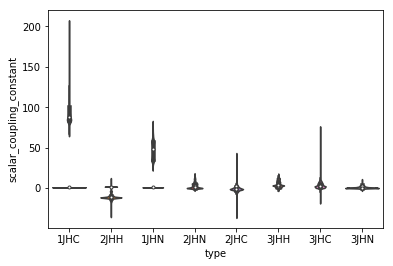

In [39]:
import seaborn as sns
sns.violinplot(x='type', y='dist', data=train);
sns.violinplot(y='scalar_coupling_constant', x='type', data=train);

Distance between atoms for 1 type has narrow distribution but the scalar coupling constant has pretty wide distribution. This is the opposite trend as compared to the 3 types
It is shown that the 1* type has much larger coupling constant as compared to the others
The atom index doesn't play a role but the type and the distance and also distortion (will be calculated, hopefully)

#### The number of big atoms (C, N, O)

In [40]:
# It could be that the number of big atoms (C,N,O) affects the coupling constant
bigatom = structure.groupby(by = ['molecule_name','atom']).size().unstack().reset_index()

In [41]:
bigatom.fillna('0', inplace = True)

In [42]:
train = pd.merge(train, bigatom, how = 'left', 
                 left_on = ['molecule_name'],
                 right_on = ['molecule_name'])

In [43]:
test = pd.merge(test, bigatom, how = 'left', 
                 left_on = ['molecule_name'],
                 right_on = ['molecule_name'])

In [44]:
train['H'] = train['H'].astype('int64')
train['F'] = train['F'].astype('int64')
train['C'] = train['C'].astype('int64')
train['N'] = train['N'].astype('int64')
train['O'] = train['O'].astype('int64')

In [45]:
test['H'] = test['H'].astype('int64')
test['F'] = test['F'].astype('int64')
test['C'] = test['C'].astype('int64')
test['N'] = test['N'].astype('int64')
test['O'] = test['O'].astype('int64')

#### Calculate angles and dihedrals

https://www.kaggle.com/scirpus/angles-and-distances

#### Further feature engineering

#### Number of atoms

In [46]:
train['typeindex'] = train.type.apply(lambda x: x[0]).astype('int64')

In [47]:
test['typeindex'] = test.type.apply(lambda x: x[0]).astype('int64')

In [48]:
xyz = structure[['x','y','z']].values
ss = structure.groupby('molecule_name').size()
ss = ss.cumsum()
ssx = np.zeros(len(ss) + 1, 'int')
ssx[1:] = ss

from numba import jit
from math import sqrt

@jit
def numba_dist_matrix(xyz, ssx, molecule_id):
    start_molecule, end_molecule = ssx[molecule_id], ssx[molecule_id+1]
    locs = xyz[start_molecule:end_molecule]     
   # return locs
    num_atoms = end_molecule - start_molecule
    return num_atoms

In [49]:
#dict = {}
def numba_dist_matrices(xyz, ssx):
    dist = {}
    for molecule_id in range(structure.molecule_name.nunique()):
        distmat = numba_dist_matrix(xyz, ssx, molecule_id)
        molecule = ss.index[molecule_id]
        subdict = {molecule: distmat}
        dist.update(subdict)
    return (dist)    


In [50]:
num_atom = numba_dist_matrices(xyz,ssx)

In [51]:
# Calculate distance / map info in train df
#train['num_atom'] = train.apply(lambda x: num_atom[x.molecule_name], axis = 1)
import math
train['num_atom'] = [num_atom[a] for a in train.molecule_name]
# convert cosine to degrees
train['cosinus'] = [math.degrees(math.acos(a)) for a in train.cosinus]
# convert radian to degrees
train['dihedral'] = [math.degrees((a)) for a in train.dihedral]

In [52]:
test['num_atom'] = [num_atom[a] for a in test.molecule_name]
test['cosinus'] = [math.degrees(math.acos(a)) for a in test.cosinus]
test['dihedral'] = [math.degrees((a)) for a in test.dihedral]

#### Some more distance based features

In [53]:
### Add some more meta-data, taken from giba features

def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    
    ###
    
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_x_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('mean')
    
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    
    df[f'molecule_atom_index_0_z_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('mean')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    #df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
   # df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    return(df)

#### Van der waals, yukawa, and coulomb interaction

In [54]:
train['van'] = train['dist'].apply(lambda x: float(1/x**3))

In [55]:
test['van'] = test['dist'].apply(lambda x: float(1/x**3))

In [56]:
#train['coulomb'] = train.apply(lambda x: -float(1/x.dist**2)*x.mulliken_charge_0*x.mulliken_charge_1, axis = 1)
train['coulomb'] = train['dist'].apply(lambda x: float(1/x**2))
#train['coulomb'] = -train['mulliken_charge_0']*train['mulliken_charge_1']* train['coulomb']

In [57]:
test['coulomb'] = test['dist'].apply(lambda x: float(1/x**2))
#test['coulomb'] = -test['mulliken_charge_0']*test['mulliken_charge_1']* test['coulomb']

In [58]:
train['yukawa'] = train['dist'].apply(lambda x: float(math.exp(-x)/x))

In [59]:
test['yukawa'] = test['dist'].apply(lambda x: float(math.exp(-x)/x))

In [60]:
train['molar_mass'] = train['C']*12 + train['F']*19 + train['H'] + train['N']*14 + train['O']*16

In [61]:
test['molar_mass'] = test['C']*12 + test['F']*19 + test['H'] + test['N']*14 + test['O']*16

In [62]:
### Create Extra features
train = create_features(train)
test = create_features(test)

In [63]:
# Drop unncessary columns

train = train.drop(['shortest_path_atoms', 'shortest_path_n_bonds',
           'id', 'molecule_name','atom_0','atom_1'], axis = 1)

In [64]:
test = test.drop(['shortest_path_atoms', 'shortest_path_n_bonds',
            'molecule_name','atom_0','atom_1'], axis = 1)

In [65]:
initfeature = train.columns

### 4. Model development

##### Train test split for different coupling type

In [66]:
# First try: 3 different models for 3 types

def splitdata(df, type):
    typedf = df[df['typeindex'] == type]
    if (type == 1):
           # ,'fc','sd','pso','dso' 
        features = initfeature.drop(['typeindex','cosinus', 'dihedral'])     
        #features = ['type','scalar_coupling_constant','num_atom','dist','van','coulomb','yukawa','C','H','N','O']
    elif (type == 2):
        features = initfeature.drop(['typeindex', 'dihedral'])
        #features = ['type','cosinus','scalar_coupling_constant','num_atom','dist','van','coulomb','yukawa','C','H','N','O']
    else:
        features = initfeature.drop(['typeindex','cosinus'])
        #features = ['type','dihedral','scalar_coupling_constant','num_atom','dist','van','coulomb','yukawa','C','H','N','O']
        
    typedf.dropna(subset = features, inplace = True)
    typedf = typedf[features]
    
    target = typedf['scalar_coupling_constant']
    
    feature = typedf.drop(['scalar_coupling_constant'], axis = 1)
    
    catfeat = pd.get_dummies(feature['type'])
    numfeat = feature.drop(['type'], axis = 1)
    
    feature = pd.concat([catfeat, numfeat, feature['type']], axis = 1)
    
    x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 1)
    
    x_train.drop(['type'], axis = 1, inplace = True)
    metric_df = pd.concat([x_test['type'],y_test], axis = 1)
    x_test.drop(['type'], axis = 1, inplace = True)
    
    return(x_train, x_test, y_train, y_test, metric_df)
    

In [67]:
# First try: 3 different models for 3 types

def splittestdata(df, type):
    typedf = df[df['typeindex'] == type]
    if (type == 1):
           # ,'fc','sd','pso','dso' 
        features = initfeature.drop(['typeindex','cosinus', 'dihedral','scalar_coupling_constant'])     
        #features = ['type','scalar_coupling_constant','num_atom','dist','van','coulomb','yukawa','C','H','N','O']
    elif (type == 2):
        features = initfeature.drop(['typeindex', 'dihedral','scalar_coupling_constant'])
        #features = ['type','cosinus','scalar_coupling_constant','num_atom','dist','van','coulomb','yukawa','C','H','N','O']
    else:
        features = initfeature.drop(['typeindex','cosinus','scalar_coupling_constant'])
        #features = ['type','dihedral','scalar_coupling_constant','num_atom','dist','van','coulomb','yukawa','C','H','N','O']
        
    feature = typedf[features]
    
    catfeat = pd.get_dummies(feature['type'])
    numfeat = feature.drop(['type'], axis = 1)
    
    feature = pd.concat([catfeat, numfeat], axis = 1)
    
    return(feature)
    

In [68]:
x_train, x_test, y_train, y_test, metric_df = splitdata(train, 3)

/Users/QD/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/QD/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [69]:
testdata = splittestdata(test,3)

In [70]:
# Only for type 3 interaction
x_train['cos'] = x_train['dihedral'].apply(lambda x: math.cos(math.radians(x)))
x_train['cos2'] = x_train['dihedral'].apply(lambda x: math.cos(2*math.radians(x)))

x_test['cos'] = x_test['dihedral'].apply(lambda x: math.cos(math.radians(x)))
x_test['cos2'] = x_test['dihedral'].apply(lambda x: math.cos(2*math.radians(x)))

### Train the model

In [71]:
from sklearn.metrics import mean_squared_error, r2_score

In [72]:
# Metrics 
from sklearn import metrics
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

In [73]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test  = sc.transform(x_test)

In [74]:
from sklearn.ensemble import RandomForestRegressor

In [75]:
RF = RandomForestRegressor()
RF.fit(x_train,y_train)
y_pred = RF.predict(x_test)

/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Evaluate

In [76]:
metric(metric_df,y_pred)

-1.0885036940437434